# HSCT survival linear regression model

## Notebook set-up

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import uniform
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV

## 1. Load data

In [2]:
# Load the datasets
dictionary_df=pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv')
training_df=pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')
testing_df=pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')

# Save the ID and drop
testing_ids=testing_df['ID']
training_df.drop('ID', axis=1, inplace=True)
testing_df.drop('ID', axis=1, inplace=True)

# Remove the labels from the training dataframe
training_labels=training_df['efs_time']
training_df.drop(['efs', 'efs_time'], axis=1, inplace=True)

print(f'Training features: {training_df.shape}')
print(f'Testing features: {testing_df.shape}')

Training features: (28800, 57)
Testing features: (3, 57)


## 2. Split categorical and numerical features

In [3]:
# Get lists of categorical and numerical column names
categorical_feature_names=dictionary_df['variable'][dictionary_df['type'] == 'Categorical']
numerical_feature_names=dictionary_df['variable'][dictionary_df['type'] == 'Numerical']

# Remove the feature column from the column names lists
categorical_feature_names=categorical_feature_names[categorical_feature_names != 'efs']
numerical_feature_names=numerical_feature_names[numerical_feature_names != 'efs_time']

# Split the training and testing dataframes
training_categorical_df=training_df[categorical_feature_names].copy()
training_numerical_df=training_df[numerical_feature_names].copy()
testing_categorical_df=testing_df[categorical_feature_names].copy()
testing_numerical_df=testing_df[numerical_feature_names].copy()

print(f'Training numerical features: {training_numerical_df.shape}')
print(f'Training categorical features: {training_categorical_df.shape}')
print(f'Testing numerical features: {testing_numerical_df.shape}')
print(f'Testing categorical features: {testing_categorical_df.shape}')

Training numerical features: (28800, 22)
Training categorical features: (28800, 35)
Testing numerical features: (3, 22)
Testing categorical features: (3, 35)


## 3. Handle missing data

### 3.1. Categorical features

In [4]:
training_categorical_df.fillna('Missing', inplace=True)
testing_categorical_df.fillna('Missing', inplace=True)

print(f'Training categorical features: {training_categorical_df.shape}')
print(f'Testing categorical features: {testing_categorical_df.shape}')

Training categorical features: (28800, 35)
Testing categorical features: (3, 35)


### 3.2. Numerical features

In [5]:
imputer=KNNImputer(n_neighbors=3, weights='uniform')
imputer.fit(training_numerical_df)

training_numerical_data=imputer.transform(training_numerical_df)
testing_numerical_data=imputer.transform(testing_numerical_df)

training_numerical_df=pd.DataFrame(training_numerical_data, columns=training_numerical_df.columns)
testing_numerical_df=pd.DataFrame(testing_numerical_data, columns=training_numerical_df.columns)

print(f'Training numerical features: {training_numerical_df.shape}')
print(f'Testing numerical features: {testing_numerical_df.shape}')

Training numerical features: (28800, 22)
Testing numerical features: (3, 22)


## 4. One-hot encode categorical features

In [6]:
encoder=OneHotEncoder(drop='first',sparse_output=False)
encoder.fit(training_categorical_df)
feature_names=encoder.get_feature_names_out()

training_categorical_data=encoder.transform(training_categorical_df)
testing_categorical_data=encoder.transform(testing_categorical_df)

training_categorical_df=pd.DataFrame(training_categorical_data, columns=feature_names)
testing_categorical_df=pd.DataFrame(testing_categorical_data, columns=feature_names)

training_features_df=pd.concat(
    [
        training_numerical_df.reset_index(drop=True), 
        training_categorical_df.reset_index(drop=True)
    ],
    axis=1
)

testing_features_df=pd.concat(
    [
        testing_numerical_df.reset_index(drop=True), 
        testing_categorical_df.reset_index(drop=True)
    ],
    axis=1
)

print(f'Training features: {training_features_df.shape}')
print(f'Testing features: {testing_features_df.shape}')

Training features: (28800, 178)
Testing features: (3, 178)


## 5. Fit and evaluate the model

In [7]:
def cross_val(model, features: pd.DataFrame, labels: pd.Series) -> list[float]:
    '''Reusable helper function to run cross-validation on a model. Takes model,
    Pandas data frame of features and Pandas data series of labels. Returns 
    list of cross-validation fold accuracy scores as percents.'''

    # Define the cross-validation strategy
    cross_validation=KFold(n_splits=7, shuffle=True, random_state=315)

    # Run the cross-validation, collecting the scores
    scores=cross_val_score(
        model,
        features,
        labels,
        cv=cross_validation,
        n_jobs=-1,
        scoring='neg_root_mean_squared_error'
    )

    # Print mean and standard deviation of the scores
    print(f'Cross validation RMSE {-scores.mean():.2f} +/- {scores.std():.2f}')

    # Return the scores
    return scores

Cross validation RMSE 22.91 +/- 0.28


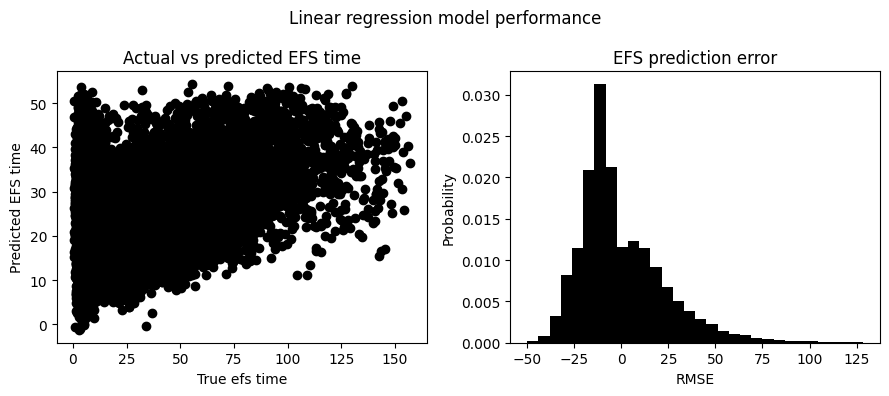

In [8]:
# Instantiate the model
model=ElasticNet(
    alpha=0.13743694392305272,
    fit_intercept=True,
    l1_ratio=0.47247598680365765,
    positive=False,
    selection='cyclic',
    max_iter=5000,
    random_state=315
)

baseline_scores=cross_val(model, training_features_df, training_labels)

model.fit(training_features_df, training_labels)
predicted_efs_time=model.predict(training_features_df)

# Set-up a 2x1 figure
fig, axs=plt.subplots(1,2, figsize=(9,4))
axs=axs.flatten()

fig.suptitle('Linear regression model performance')

axs[0].set_title('Actual vs predicted EFS time')
axs[0].scatter(training_labels, predicted_efs_time, color='black')
axs[0].set_xlabel('True efs time')
axs[0].set_ylabel('Predicted EFS time')

axs[1].set_title('EFS prediction error')
axs[1].hist(training_labels-predicted_efs_time, density=True, bins=30, color='black')
axs[1].set_xlabel('RMSE')
axs[1].set_ylabel('Probability')

plt.tight_layout()
plt.show()

## 6. Make test set predictions

In [9]:
predicted_efs_time=model.predict(testing_features_df)
scaler=MinMaxScaler()
scaler.fit(predicted_efs_time.reshape(-1, 1))
predicted_efs_time=scaler.transform(predicted_efs_time.reshape(-1, 1))

predictions_df=pd.DataFrame.from_dict(
    {
        'ID': testing_ids,
        'prediction': predicted_efs_time.flatten()
    }
)

predictions_df.head()

,ID,prediction
0,28800,0.66592
1,28801,1.00000
2,28802,0.00000


In [10]:
predictions_df.to_csv('submission.csv', index=False)